Processing variable: pr_mean_annual_clim_mean

--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.processing_level.xrfreq'


/tmp/ipykernel_1847263/1215887491.py:14: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



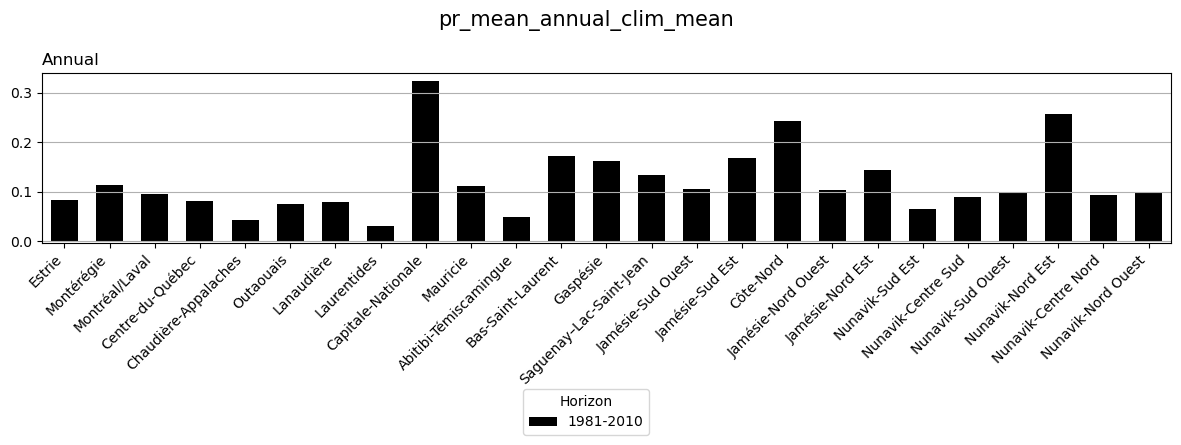

Processing variable: tg_mean_seasonal_clim_mean

--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.processing_level.xrfreq'


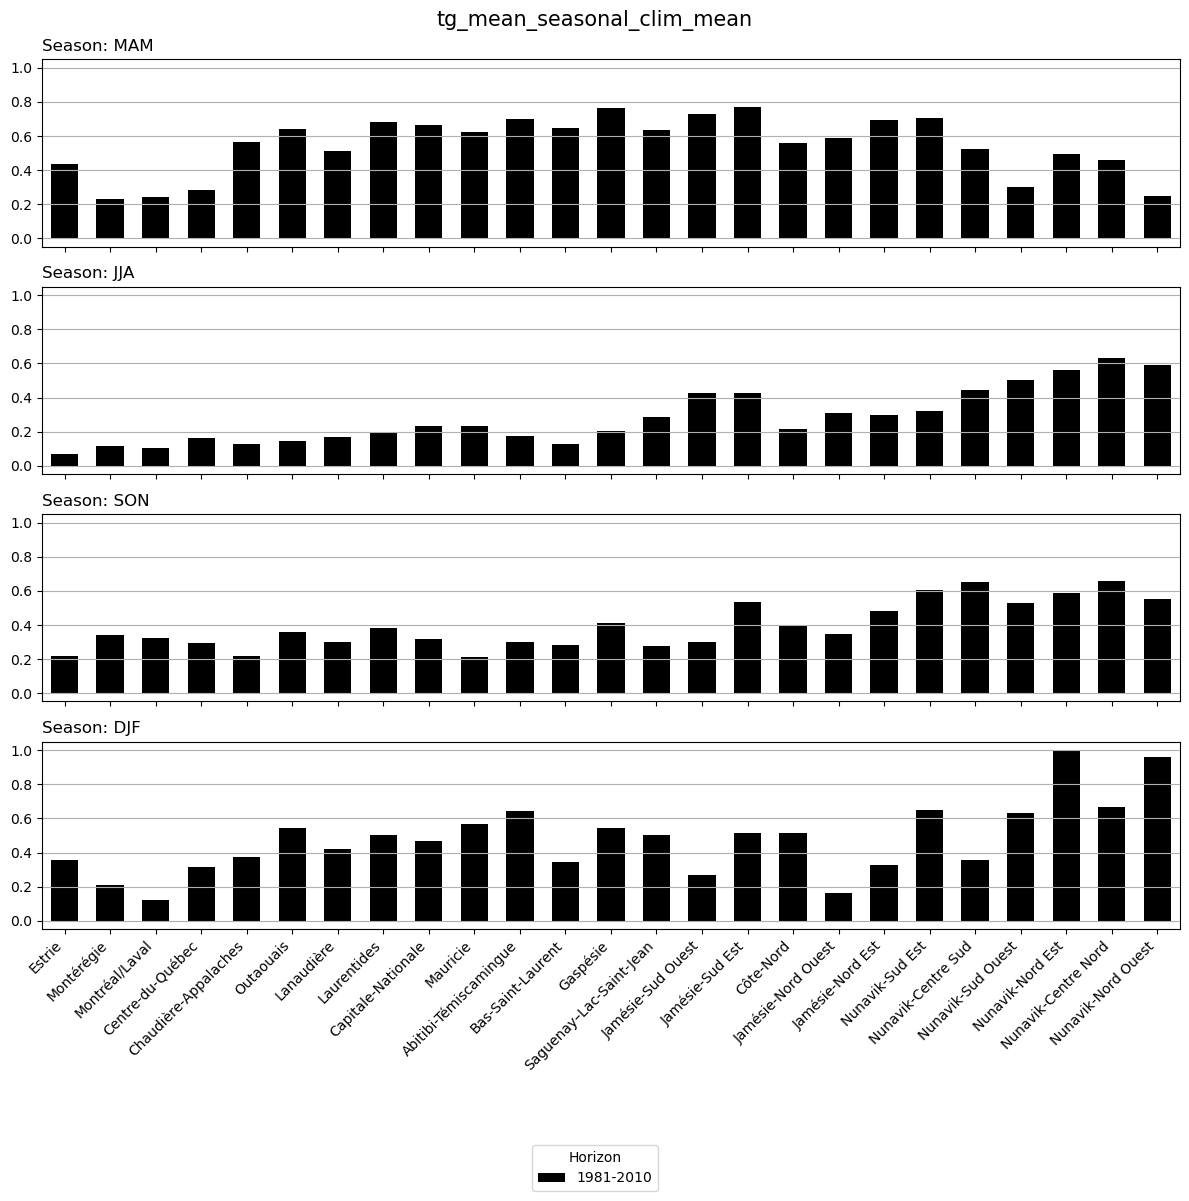

Processing variable: tg_mean_annual_clim_mean

--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.processing_level.xrfreq'


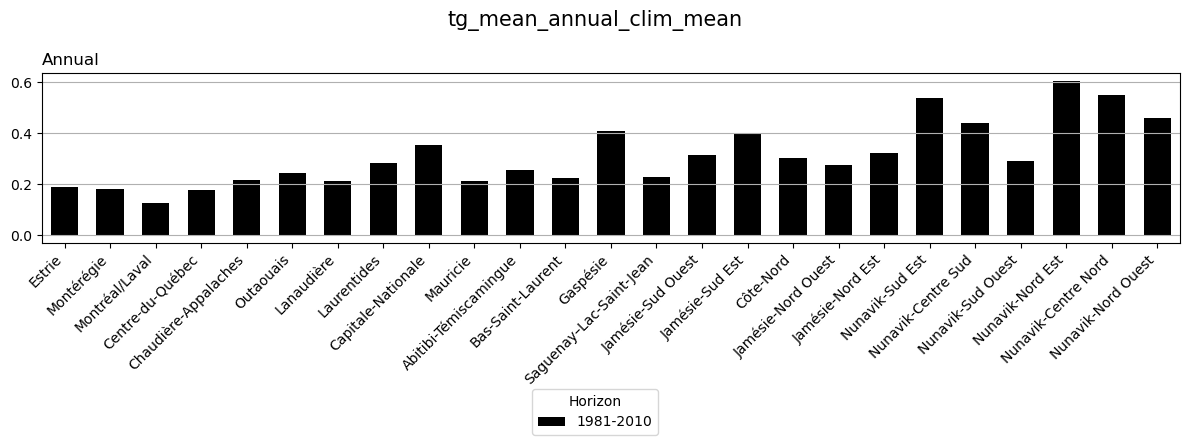

Processing variable: pr_mean_seasonal_clim_mean

--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.processing_level.xrfreq'


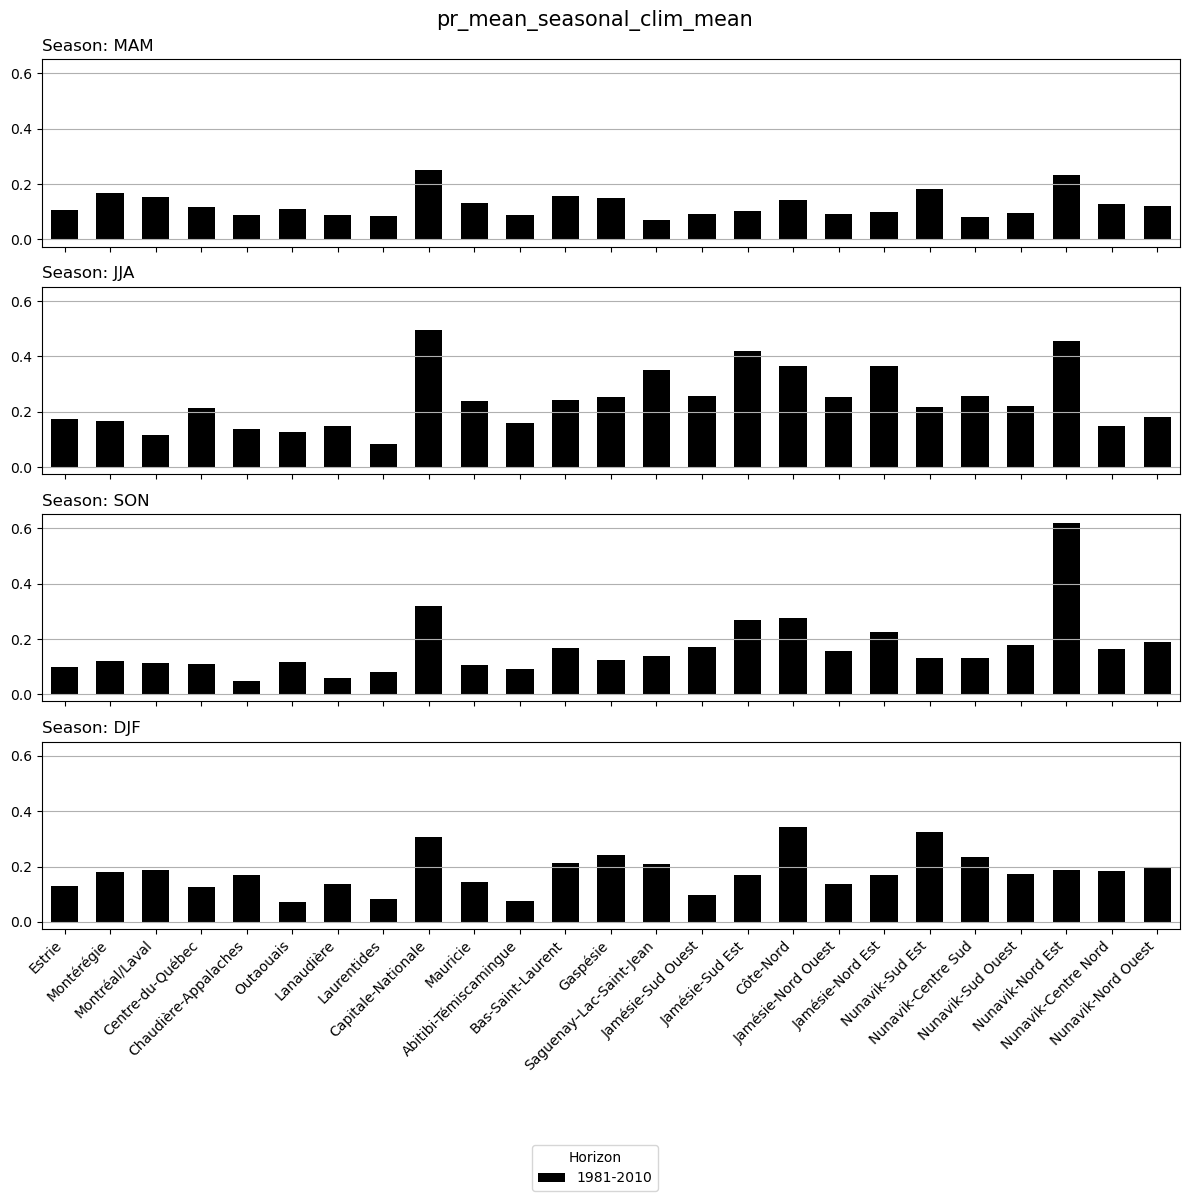

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import xscen as xs
from xscen.config import CONFIG

# Load config and project catalog
xs.load_config("../paths_obs.yml", "../config_obs.yml", verbose=(__name__ == "__main__"), reset=True)
pcat = xs.ProjectCatalog(CONFIG["paths"]["project_catalog"])
pcat_df = pcat.df

# Load shapefile and get region order (south to north)
gdf = gpd.read_file("../" + CONFIG["regional_mean"]["region"]["shape"])
gdf["centroid_y"] = gdf.geometry.centroid.y
REGION_ORDER = gdf.sort_values("centroid_y")["name"].tolist()

# Horizon colors (customize if needed)
HORIZON_COLORS = {
    "1981-2010": "black",
    "1991-2020": "#fdae6b",
    # Add more if needed
}

# === MAIN LOOP ===
pcat_df_perf = pcat_df[pcat_df["processing_level"] == "coherence"]
variable_groups = pcat_df_perf["variable"].unique()
variables = set(item for group in variable_groups for item in group)

for perf_var in variables:
    print(f"Processing variable: {perf_var}")

    dss_std = pcat.search(processing_level="coherence", variable=perf_var).to_dataset_dict()
    for ds_std in dss_std.values():
        if perf_var not in ds_std:
            print(f"Variable '{perf_var}' not found.")
            continue

        da = ds_std[perf_var]
        has_season = "season" in da.dims
        seasons = da["season"].values if has_season else [None]
        regions = REGION_ORDER

        # Filter to only the 1981-2010 horizon
        if "horizon" not in da.dims or "1981-2010" not in da["horizon"].values:
            print(f"Horizon '1981-2010' not found in dataset for {perf_var}.")
            continue
        horizons = ["1981-2010"]

        # Compute y limits
        ymin = float(da.min())
        ymax = float(da.max())
        y_pad = 0.05 * (ymax - ymin) if ymax > ymin else 1.0
        bar_width = 0.6  # No need to divide by len(horizons) since there's only one

        # Figure setup
        n_rows = len(seasons)
        fig_height = 2.75 * n_rows if n_rows > 1 else 4
        fig, axes = plt.subplots(nrows=n_rows, ncols=1, figsize=(12, fig_height), sharex=True)
        if n_rows == 1:
            axes = [axes]

        for i, season in enumerate(seasons):
            ax = axes[i]
            da_season = da.sel(season=season) if has_season else da
            x = np.arange(len(regions))

            for horizon in horizons:
                y = da_season.sel(horizon=horizon).reindex(region=regions).values
                color = HORIZON_COLORS.get(horizon, None)
                bar_pos = x  # Centered bars

                ax.bar(bar_pos, y, width=bar_width, color=color, label=str(horizon), alpha=1)

            title = f"Season: {season}" if season else "Annual"
            ax.set_title(title, loc='left')
            ax.set_ylim(ymin - y_pad, ymax + y_pad)
            ax.grid(True, axis='y')

        # Bottom labels
        axes[-1].set_xticks(x)
        axes[-1].set_xticklabels(regions, rotation=45, ha='right')
        axes[-1].set_xlim(-0.5, len(regions) - 0.5)

        # Shared legend
        handles, labels = axes[0].get_legend_handles_labels()
        uniq = dict(zip(labels, handles))
        fig.legend(uniq.values(), uniq.keys(), title="Horizon", loc='lower center',
                   ncol=len(uniq), bbox_to_anchor=(0.5, -0.1))

        # Final title and layout
        fig.suptitle(perf_var, fontsize=15, y=0.98)
        fig.subplots_adjust(bottom=0.18, top=0.9)
        plt.tight_layout()
        plt.show()
